In [3]:
# import the necessary libraries
import numpy as np
from scipy.io import loadmat
import os
import h5py
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
plt.style.use('bmh')
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False

os.getcwd()
os.chdir('..')
os.chdir('data')
file_path = os.getcwd() + '/'
os.chdir('..')
os.chdir('figures')
figure_path = os.getcwd() + '/'

### data upload

In [4]:
# uncomment this code if you are uploading the data from your local machine
peak_diag_disp = loadmat(file_path + 'peak_disp_diag.mat')
peak_antidiag_disp = loadmat(file_path + 'peak_disp_antidiag.mat')

# get the diagonal particle displacement
diag_part_disp = h5py.File(file_path + 'Dp.mat', 'r')

# get the antidiagonal particle displacement
antidiag_part_disp = h5py.File(file_path + 'Ap.mat', 'r')

In [5]:
# define the data class for easier parsing
class SimSetup:
    def __init__(self, diag_part_disp, antidiag_part_disp, peak_diag_disp, peak_antidiag_disp):
        self.diag_part_disp = np.transpose(diag_part_disp['Diagp'][()], (2, 1, 0))
        self.antidiag_part_disp = np.transpose(antidiag_part_disp['Antidiagp'][()], (2, 1, 0))
        self.peak_antidiag_disp = peak_antidiag_disp['peak_disp_antidiagt']
        self.peak_diag_disp = peak_diag_disp['peak_disp_diagt']

In [6]:
trxd = SimSetup(diag_part_disp=diag_part_disp, 
                antidiag_part_disp=antidiag_part_disp, 
                peak_diag_disp=peak_diag_disp,
                peak_antidiag_disp=peak_antidiag_disp)

In [7]:
# simulation parameters
Nx = 300                 # grid points
Ny = 300                 # grid points
dx = 0.2e-3              # resolution in x [m]
dy = 0.2e-3              # resolution in y [m]
dz = 0.2e-3 * np.sqrt(2) # diagonal (and antidiagonal) resolution [m]

# Define a dynamic extent for setting the "extent" parameter in matplotlib
def dynamic_extent(x, y):
    return (x * dx * 1e3, (Nx-x) * dx * 1e3,
            (-Ny + 2 * y) * dy * 1e3 / 2, (Ny - 2 * y) * dy * 1e3 / 2)

### Tissue Displacement due to Acoustic Radiation Force

In [8]:
tissue_disp_max = max(np.max(trxd.peak_diag_disp[50:-50, 50:-50]), 
                      np.max(trxd.peak_antidiag_disp[50:-50, 50:-50]))
tissue_disp_min = min(np.min(trxd.peak_diag_disp[50:-50, 50:-50]), 
                      np.min(trxd.peak_antidiag_disp[50:-50, 50:-50]))

# Extract the absolute maximum and absolute minimum values for standardization
tissue_disp_max = max(tissue_disp_max, abs(tissue_disp_min))
tissue_disp_min = min(-tissue_disp_max, tissue_disp_min)

# Normalize to -1 and 1
peak_diag_disp_norm = (2 * (trxd.peak_diag_disp - tissue_disp_min) / 
                       (tissue_disp_max -  tissue_disp_min) - 1)
peak_antidiag_disp_norm = (2 * (trxd.peak_antidiag_disp - tissue_disp_min) / 
                           (tissue_disp_max -  tissue_disp_min) - 1)

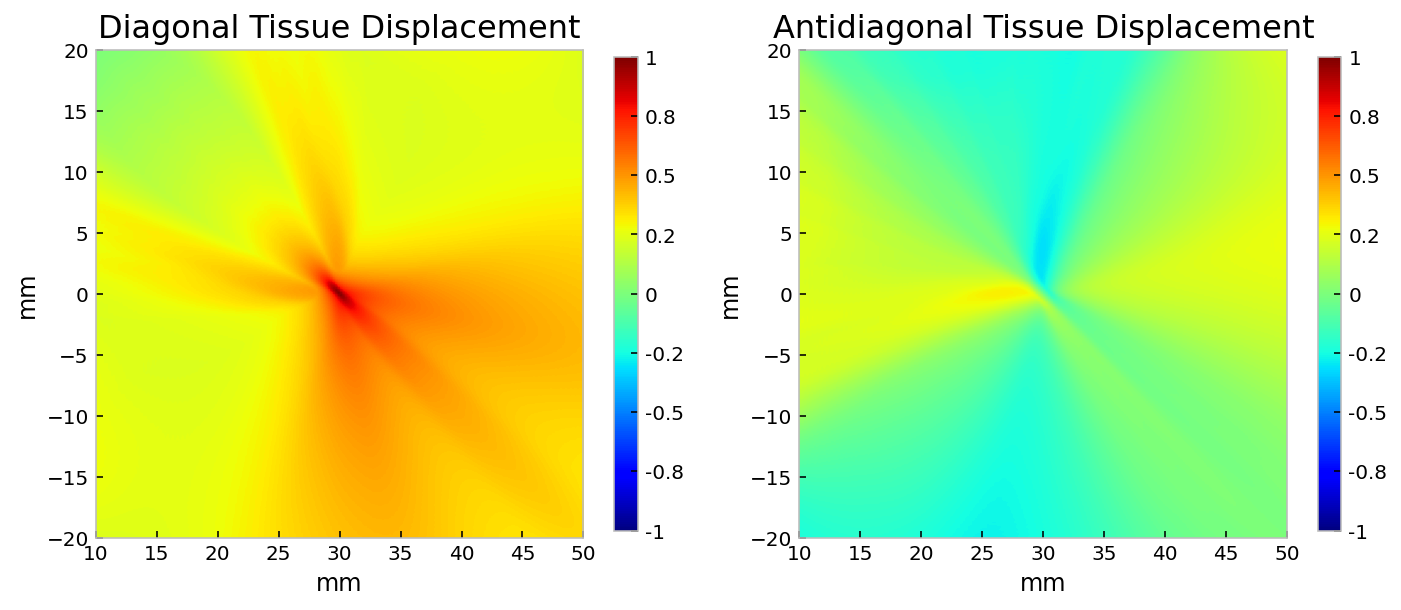

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Diagonal Tissue Displacement', fontsize=16)
plt.imshow(peak_diag_disp_norm[50:-50, 50:-50],
           extent=dynamic_extent(50, 50), cmap='jet')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('mm')
plt.ylabel('mm')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.title('Antidiagonal Tissue Displacement', fontsize=16)
plt.imshow(peak_antidiag_disp_norm[50:-50, 50:-50],
           extent=dynamic_extent(50, 50), cmap='jet')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('mm')
plt.ylabel('mm')
plt.grid(False)

plt.tight_layout()
#plt.savefig(figure_path + 'tissue_displacement.png', dpi=600)
plt.show()

### Particle Displacement due to Pressure

In [10]:
part_disp_max = max(np.max(trxd.diag_part_disp[50:-50, 50:-50, :]), 
                    np.max(trxd.antidiag_part_disp[50:-50, 50:-50, :]))
part_disp_min = min(np.min(trxd.diag_part_disp[50:-50, 50:-50, :]), 
                    np.min(trxd.antidiag_part_disp[50:-50, 50:-50, :]))

# extract the absolute maximum and absolute minimum values for standardization
part_disp_max = max(part_disp_max, abs(part_disp_min))
part_disp_min = min(-part_disp_max, part_disp_min)

# standardize the displacements 
diag_part_disp_norm = (2 * (trxd.diag_part_disp - part_disp_min) /
                       (part_disp_max -  part_disp_min) - 1)
antidiag_part_disp_norm = (2 * (trxd.antidiag_part_disp - part_disp_min) /
                           (part_disp_max -  part_disp_min) - 1)

In [11]:
_, _, t_diag = ind = np.unravel_index(np.argmax(trxd.diag_part_disp[50:-50, 50:-50, :], axis=None), 
                                      trxd.diag_part_disp[50:-50, 50:-50, :].shape)
_, _, t_antidiag = ind = np.unravel_index(np.argmax(trxd.antidiag_part_disp[50:-50, 50:-50, :], axis=None), 
                                          trxd.antidiag_part_disp[50:-50, 50:-50, :].shape)

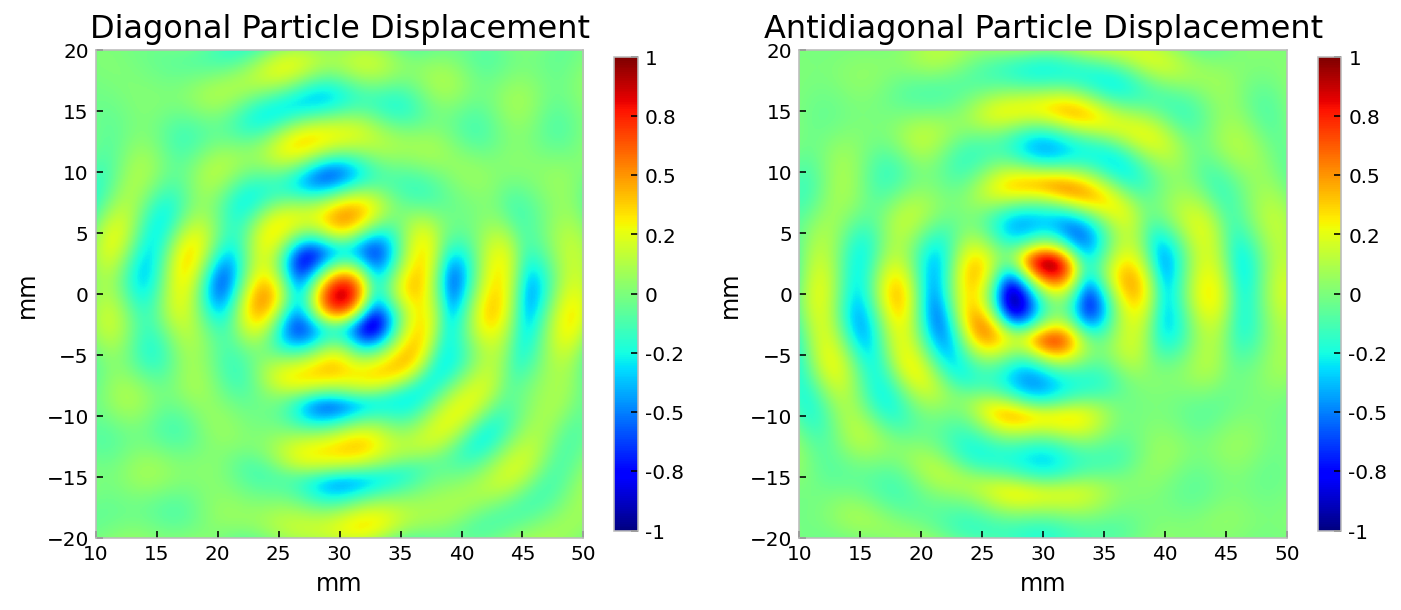

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Diagonal Particle Displacement', fontsize=16)
plt.imshow(diag_part_disp_norm[50:-50, 50:-50, t_diag],
           extent=dynamic_extent(50, 50), cmap='jet')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('mm')
plt.ylabel('mm')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.title('Antidiagonal Particle Displacement', fontsize=16)
plt.imshow(antidiag_part_disp_norm[50:-50, 50:-50, t_antidiag],
           extent=dynamic_extent(50, 50), cmap='jet')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('mm')
plt.ylabel('mm')
plt.grid(False)

plt.tight_layout()
#plt.savefig(figure_path + 'particle_displacement.png', dpi=600)
plt.show()

### Strain due to Tissue Displacement ($\mathcal{E}^{ARF}$)
Since tissue displacement is caused by acoustic radiation force, we will denote this strain by $\mathcal{E}^{ARF}$.

In [13]:
def orthogonal_gradient(diag_disp, antidiag_disp, res, dimensions):
    if dimensions == 2:
        # diagonal
        p_backward = np.zeros((Nx, Ny))
        p_forward = np.zeros((Nx, Ny))

        p_backward[1:, 1:] = diag_disp[:-1, :-1]
        p_forward[:-1, :-1] = diag_disp[1:, 1:]

        grad_diag = (p_forward - p_backward) / (2 * res)
        
        # antidiagonal
        p_backward = np.zeros((Nx, Ny))
        p_forward = np.zeros((Nx, Ny))

        p_backward[:-1, 1:] = antidiag_disp[1:, :-1]
        p_forward[1:, :-1] = antidiag_disp[:-1, 1:]

        grad_antidiag = (p_forward - p_backward) / (2 * res)
        
        # shear
        p_backward = np.zeros((Nx, Ny))
        p_forward = np.zeros((Nx, Ny))

        p_backward[:-1, 1:] = diag_disp[1:, :-1]
        p_forward[1:, :-1] = diag_disp[:-1, 1:]

        grad_shear = (p_forward - p_backward) / (2 * res)
            
    elif dimensions == 3:
        # diagonal
        p_backward = np.zeros_like(diag_disp)
        p_forward = np.zeros_like(diag_disp)

        p_backward[1:, 1:, :] = diag_disp[:-1, :-1, :]
        p_forward[:-1, :-1, :] = diag_disp[1:, 1:, :]

        grad_diag = (p_forward - p_backward) / (2 * res)

        # antidiagonal
        p_backward = np.zeros_like(diag_disp)
        p_forward = np.zeros_like(diag_disp)

        p_backward[:-1, 1:, ] = antidiag_disp[1:, :-1, :]
        p_forward[1:, :-1, ] = antidiag_disp[:-1, 1:, :]

        grad_antidiag = (p_forward - p_backward) / (2 * res)
        
        # shear
        p_backward = np.zeros_like(diag_disp)
        p_forward = np.zeros_like(diag_disp)

        p_backward[:-1, 1:, :] = diag_disp[1:, :-1, :]
        p_forward[1:, :-1, :] = diag_disp[:-1, 1:, :]

        grad_shear = (p_forward - p_backward) / (2 * res)

    return grad_diag, grad_antidiag, grad_shear

In [14]:
ARF_ediag, ARF_eantidiag, ARF_eshear = orthogonal_gradient(trxd.peak_diag_disp, 
                                                          trxd.peak_antidiag_disp,
                                                          res=dz,
                                                          dimensions=2)

In [15]:
ARF_strain_max = max(np.max(ARF_ediag[50:-50, 50:-50]),
                     np.max(ARF_eantidiag[50:-50, 50:-50]),
                     np.max(ARF_eshear[50:-50, 50:-50]))
ARF_strain_min = min(np.min(ARF_ediag[50:-50, 50:-50]),
                     np.min(ARF_eantidiag[50:-50, 50:-50]),
                     np.min(ARF_eshear[50:-50, 50:-50]))

absolute_max = max(ARF_strain_max, abs(ARF_strain_min))
absolute_min = min(-ARF_strain_max, ARF_strain_min)

ARF_ediag_norm = 2 * (ARF_ediag - absolute_min) / (absolute_max -  absolute_min) - 1
ARF_eantidiag_norm = 2 * (ARF_eantidiag - absolute_min) / (absolute_max -  absolute_min) - 1
ARF_eshear_norm = 2 * (ARF_eshear - absolute_min) / (absolute_max -  absolute_min) - 1

In [16]:
print(f'ARF max normal diagonal strain: {np.max(abs(ARF_ediag[50:-50, 50:-50]))}')
print(f'ARF max normal antidiagonal strain: {np.max(abs(ARF_eantidiag[50:-50, 50:-50]))}')
print(f'ARF max shear strain: {np.max(abs(ARF_eshear[50:-50, 50:-50]))}')

ARF max normal diagonal strain: 2.0803886391362878e-07
ARF max normal antidiagonal strain: 5.375817239278158e-07
ARF max shear strain: 5.237041703076708e-07


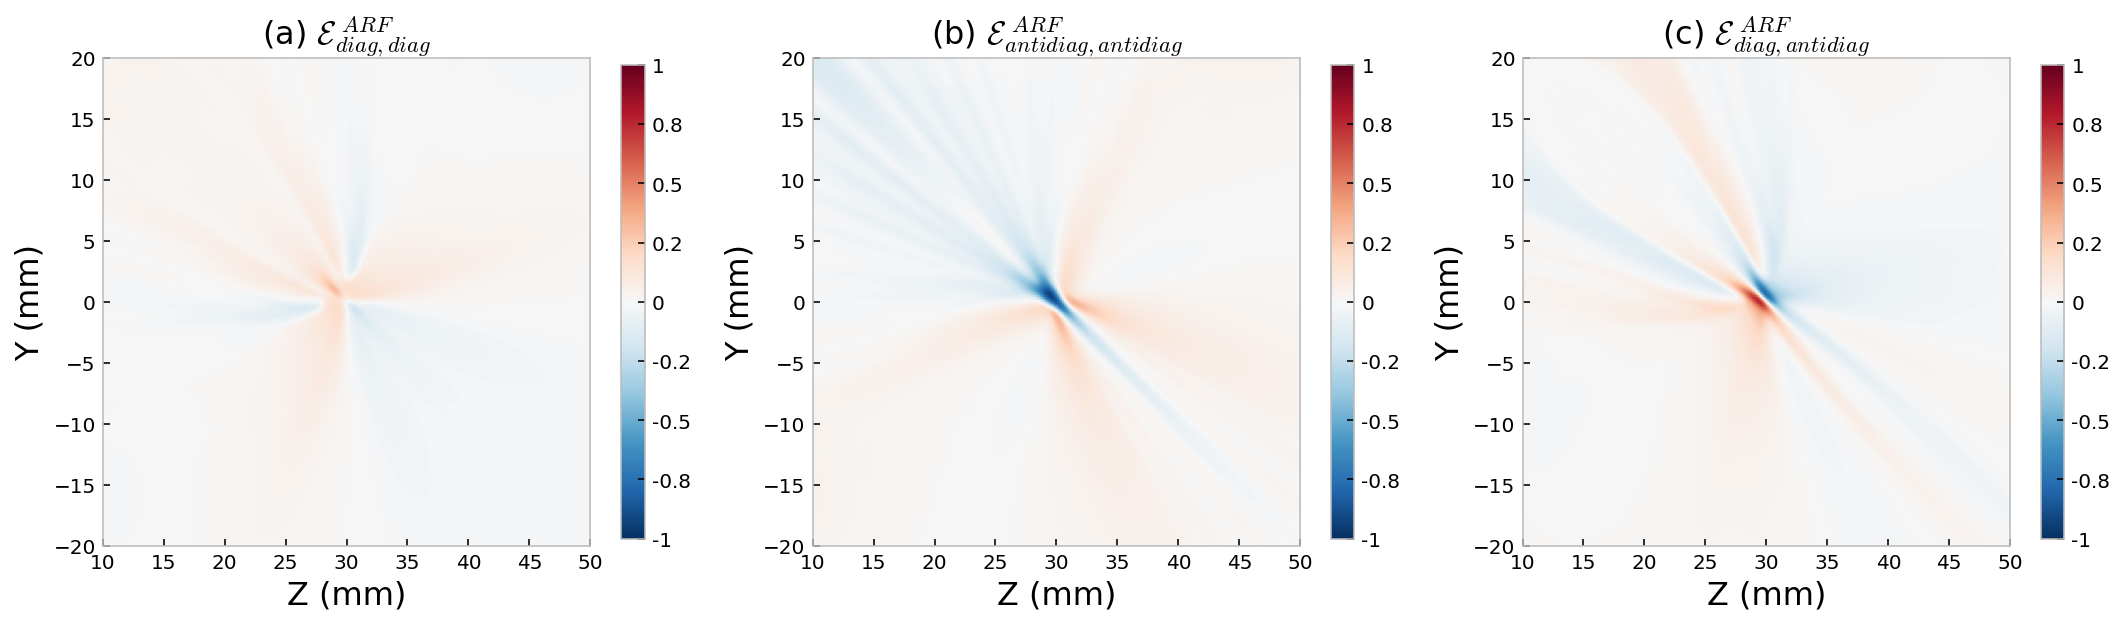

In [17]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('(a) $\mathcal{E}^{\ ARF}_{diag, diag}$', fontsize=16)
plt.imshow(gaussian_filter(ARF_ediag_norm[50:-50, 50:-50], 1),
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.subplot(1, 3, 2)
plt.title('(b) $\mathcal{E}^{\ ARF}_{antidiag, antidiag}$', fontsize=16)
plt.imshow(gaussian_filter(ARF_eantidiag_norm[50:-50, 50:-50], 1),
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.subplot(1, 3, 3)
plt.title('(c) $\mathcal{E}^{\ ARF}_{diag, antidiag}$', fontsize=16)
plt.imshow(gaussian_filter(ARF_eshear_norm[50:-50, 50:-50], 1),
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.tight_layout()
#plt.savefig(figure_path + 'ARF_strain.png', dpi=600)
plt.show()

### Strain due to Particle Displacement ($\mathcal{E}^{PM}$)
Since particle displacement is caused by instantaneous, periodic particle motion under acoustic pressure, we will denote this strain by $\mathcal{E}^{PM}$.

In [18]:
PM_Ediag, PM_Eantidiag, PM_Eshear = orthogonal_gradient(trxd.diag_part_disp[:, :, t_diag], 
                                                          trxd.antidiag_part_disp[:, :, t_antidiag],
                                                          res=dz,
                                                          dimensions=2)

In [19]:
PM_strain_max = max(np.max(PM_Ediag[50:-50, 50:-50]),
                     np.max(PM_Eantidiag[50:-50, 50:-50]),
                     np.max(PM_Eshear[50:-50, 50:-50]))
PM_strain_min = min(np.min(PM_Ediag[50:-50, 50:-50]),
                     np.min(PM_Eantidiag[50:-50, 50:-50]),
                     np.min(PM_Eshear[50:-50, 50:-50]))

PM_strain_max = max(PM_strain_max, abs(PM_strain_min))
PM_strain_min = min(-PM_strain_max, PM_strain_min)

PM_Ediag_norm = 2 * (PM_Ediag - PM_strain_min) / (PM_strain_max -  PM_strain_min) - 1
PM_Eantidiag_norm = 2 * (PM_Eantidiag - PM_strain_min) / (PM_strain_max -  PM_strain_min) - 1
PM_Eshear_norm = 2 * (PM_Eshear - PM_strain_min) / (PM_strain_max -  PM_strain_min) - 1

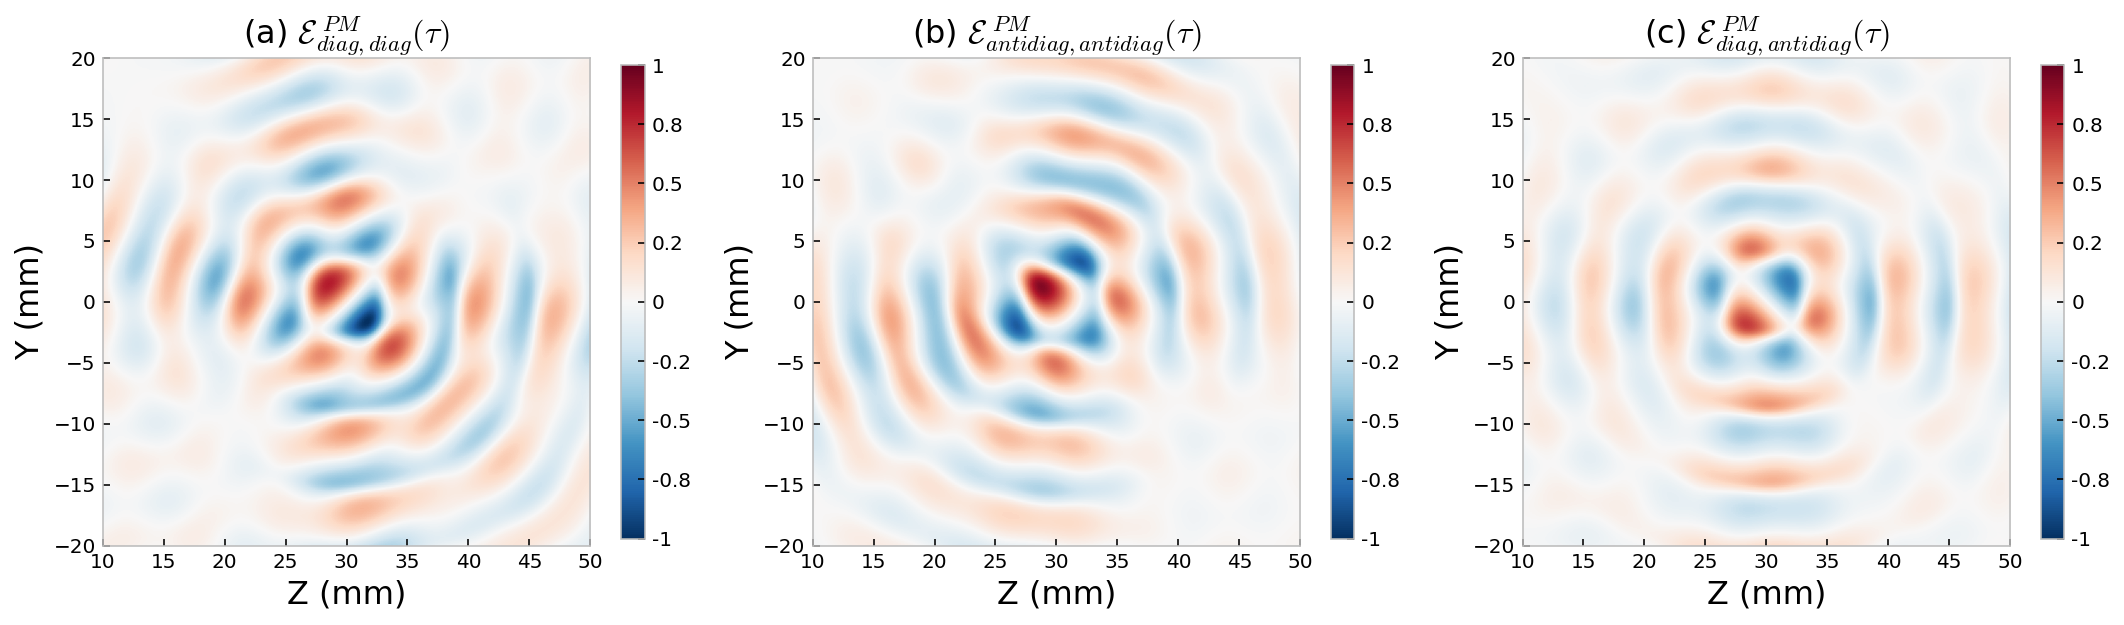

In [20]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title(r'(a) $\mathcal{E}^{\ PM}_{diag, diag} (\tau)$', fontsize=16)
plt.imshow(PM_Ediag_norm[50:-50, 50:-50],
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.subplot(1, 3, 2)
plt.title(r'(b) $\mathcal{E}^{\ PM}_{antidiag, antidiag} (\tau)$', fontsize=16)
plt.imshow(PM_Eantidiag_norm[50:-50, 50:-50],
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.subplot(1, 3, 3)
plt.title(r'(c) $\mathcal{E}^{\ PM}_{diag, antidiag} (\tau)$', fontsize=16)
plt.imshow(PM_Eshear_norm[50:-50, 50:-50],
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.tight_layout()
#plt.savefig(figure_path + 'PM_strain.png', dpi=600)
plt.show()

In [48]:
PM_ediag_temp, PM_eantidiag_temp, PM_eshear_temp = orthogonal_gradient(trxd.diag_part_disp[:, :, :], 
                                                          trxd.antidiag_part_disp[:, :, :],
                                                          res=dz,
                                                          dimensions=3)

In [49]:
PM_ediag_envelope = np.max(PM_ediag_temp[50:-50, 50:-50, :] , axis=2)
PM_eantidiag_envelope = np.max(PM_eantidiag_temp[50:-50, 50:-50, :] , axis=2)
PM_eshear_envelope = np.max(PM_eshear_temp[50:-50, 50:-50, :] , axis=2)

In [50]:
for i in [PM_ediag_envelope, PM_eantidiag_envelope, PM_eshear_envelope]:
    print(f'peak PM:  {np.max(i)}')

peak PM:  0.003883765344880885
peak PM:  0.004100717276855903
peak PM:  0.0033615971517519942


In [51]:
PM_eantidiag_envelope = np.max(PM_eantidiag_temp[:, :, :], axis=2)
PM_eantidiag_envelope_norm = PM_eantidiag_envelope / np.max(PM_eantidiag_envelope[50:-50, 50:-50])

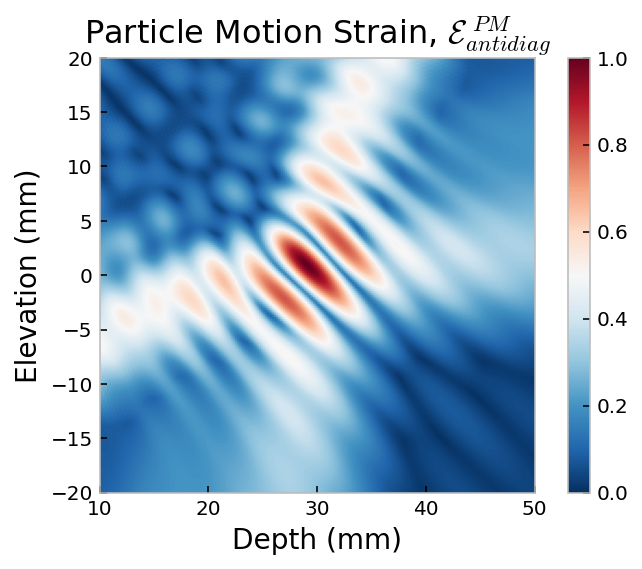

In [52]:
plt.title('Particle Motion Strain, $\mathcal{E}^{\ PM}_{antidiag}$', fontsize=16)
plt.imshow(PM_eantidiag_envelope_norm[50:-50, 50:-50],
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.grid(False)
plt.colorbar()
plt.clim(0, 1)
plt.xlabel('Depth (mm)', fontsize=14)
plt.ylabel('Elevation (mm)', fontsize=14)

#plt.savefig(figure_path + 'PM_strain_max.png', dpi=600)
plt.show()

### Comparing Independently Normalized Strain Fields

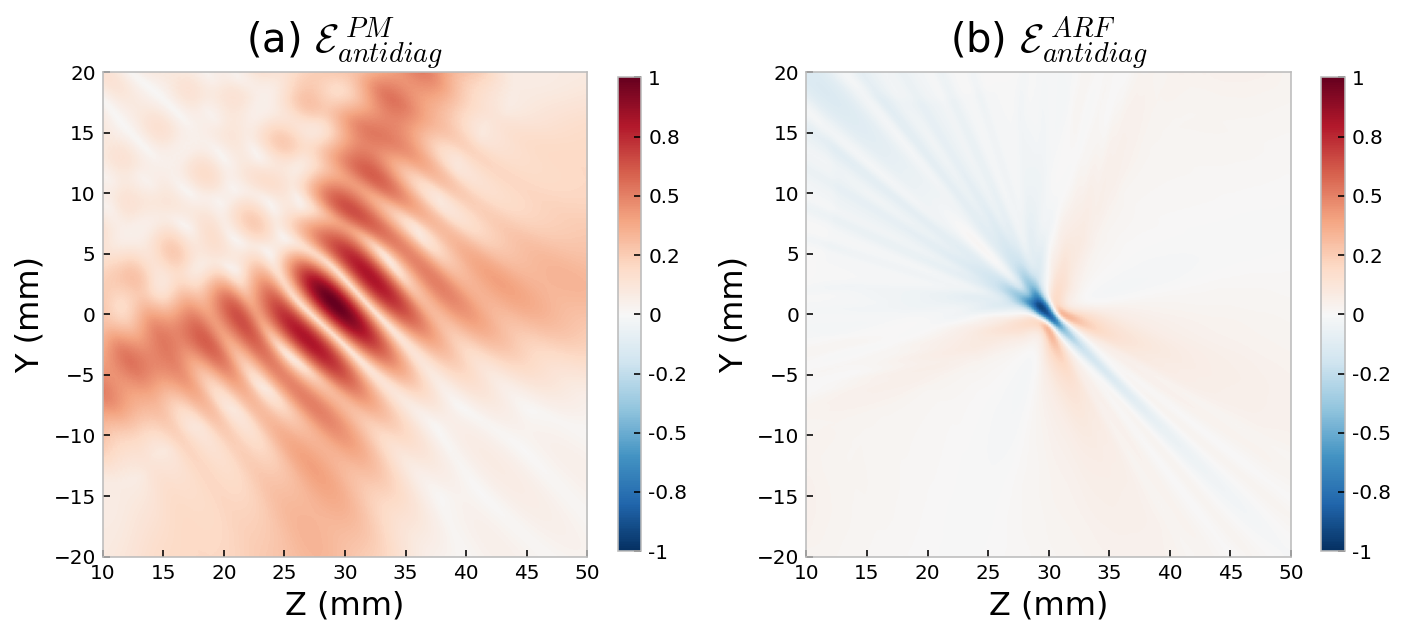

In [53]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('(a) $\mathcal{E}^{\ PM}_{antidiag}$', fontsize=20)
plt.imshow(PM_eantidiag_envelope_norm[50:-50, 50:-50],
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.grid(False)
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)

plt.subplot(1, 2, 2)
plt.title('(b) $\mathcal{E}^{\ ARF}_{antidiag}$', fontsize=20)
plt.imshow(gaussian_filter(ARF_eantidiag_norm[50:-50, 50:-50], 1),
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.tight_layout()
#plt.savefig(figure_path + 'ARF_PM_strain_comparison.png', dpi=600)
plt.show()

Save the peak strain components, both PM strain and ARF strain, for comparison against other configurations:

In [54]:
np.save(file_path + 'PM_strain_antidiag', PM_eantidiag_envelope)
np.save(file_path + 'ARF_strain_antidiag', ARF_eantidiag)